# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem defition

> How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [ ]:
# Import training and validation data

df = pd.read_csv('data/bluebook-for-bulldozers/TrainAndValid.csv', low_memory=False)

In [ ]:
# Check the data types of the columns
df.info()

In [ ]:
# Check the first 5 rows of the data
df.head()

In [ ]:
# Check the number of missing values in each column
df.isna().sum()

In [ ]:
# Visualize the data to understand the data better
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

In [ ]:
df.SalePrice.plot.hist();

### Parsing dates 

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

In [ ]:
# Import the data again with the 'saledate' column parsed as a datetime object

df = pd.read_csv('data/bluebook-for-bulldozers/TrainAndValid.csv', low_memory=False, parse_dates=['saledate'])

fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

## Sort the data by the 'saledate' column

This is important because we are working with time series data

In [ ]:
# Sort the data by the 'saledate' column
df.sort_values(by=['saledate'], inplace=True, ascending=True)
df.saledate.head(20)

## Make a copy of the original DataFrame

We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.


In [ ]:
# Make a copy of the original dataframe
df_tmp = df.copy()

### Add datetime parameters for `saledate` column


In [ ]:
df_tmp['saleYear'] = df_tmp.saledate.dt.year
df_tmp['saleMonth'] = df_tmp.saledate.dt.month
df_tmp['saleDay'] = df_tmp.saledate.dt.day
df_tmp['saleDayOfWeek'] = df_tmp.saledate.dt.dayofweek
df_tmp['saleDayOfYear'] = df_tmp.saledate.dt.dayofyear

# Now that we have enriched our DataFrame with date time features, we can remove 'saledate' column
df_tmp.drop('saledate', axis=1, inplace=True)

## 5. Modelling

We've explored the data, now we'll do some model-driven EDA (Exploratory Data Analysis).

In [ ]:
# Lets build a machine learning model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=42)
#Random_state acts like np.random_seed()

x = df_tmp.drop('SalePrice', axis=1)
y = df_tmp['SalePrice']

model.fit(x, y)


In [ ]:
df_tmp.info()

In [ ]:
df_tmp.isna().sum() 

### Convert string to categories

One way we can turn all of our data into numbers is by converting them into pandas categories.

We can check the different datatypes compatible with pandas here: https://pandas.pydata.org/pandas-docs/version/0.25/reference/general_utility_functions.html#data-types-related-functionality

In [ ]:
# Find the columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)
        

In [ ]:
# .items() method returns a tuple of column name and column content
random_dict = {'key1': 'hello',
               'key2': 'world!'}

for key, value in random_dict.items():
    print(f'This is a key: {key}',
          f'This is a value: {value}')
    

In [ ]:
# This is how we can convert string values into categories
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content) or pd.api.types.is_object_dtype(content):
        df_tmp[label] = content.astype('category').cat.as_ordered()

In [ ]:
df_tmp.info()

In [ ]:
df_tmp.state.cat.categories

In [ ]:
# Now we can convert the categories into numbers
df_tmp.state.cat.codes

Thanks to pandas Categories we can now access all of our data in the form of numbers.

But we still have a bunch of missing data...

In [ ]:
# Check missing data
df_tmp.isna().sum() / len(df_tmp)

### Save preprocessed data

In [ ]:
# Export the preprocessed data to a new file (df_tmp)
df_tmp.to_csv('data/bluebook-for-bulldozers/train_tmp.csv', index=False)


In [ ]:
# Import the preprocessed data
df_tmp = pd.read_csv('data/bluebook-for-bulldozers/train_tmp.csv', low_memory=False)

In [ ]:
df_tmp.head().T

## Fill missing values

### Fill numerical missing values first

In [ ]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

In [ ]:
# Check which numeric columns have missing values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [ ]:
# Fill the missing values with the median in numeric columns
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing
            df_tmp[label + '_is_missing'] = pd.isnull(content)
            # Fill the missing values with median
            df_tmp[label] = content.fillna(content.median())

In [ ]:
# Check if there are any missing values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [ ]:
# Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

In [ ]:
df_tmp.isna().sum()

### Filling and turning categorical variables into numbers


In [ ]:
# Check for columns which are not numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

In [ ]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_tmp[label + '_is_missing'] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes + 1
        
df_tmp.head().T

In [ ]:
df_tmp.isna().sum()

### Now that we have no missing values and all the data is numeric, we can build a machine learning model

In [ ]:
df_tmp.head()

In [ ]:
len(df_tmp)

In [ ]:
%%time
# Instantiate the model
model = RandomForestRegressor(n_jobs=-1, random_state=42)

x = df_tmp.drop('SalePrice', axis=1)
y = df_tmp['SalePrice']

# Fit Model
model.fit(x, y)


### Splitting the data into training and validation sets

In [ ]:
df_tmp.saleYear.value_counts()

In [ ]:
# Split the data into training and validation sets
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

In [ ]:
# Split the data into x and y
x_train, y_train = df_train.drop('SalePrice', axis=1), df_train['SalePrice']
x_valid, y_valid = df_val.drop('SalePrice', axis=1), df_val['SalePrice']

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

## Building an evaluation function

In [ ]:
# Create an evaluation function (RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    '''
    Calculates root mean squared log error between predictions and true labels
    '''
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create a function to evaluate the model on a few different levels
def show_scores(model):
    train_preds = model.predict(x_train)
    val_preds = model.predict(x_valid)
    scores = {'Training MAE': mean_absolute_error(y_train, train_preds),
              'Valid MAE': mean_absolute_error(y_valid, val_preds),
              'Training RMSLE': rmsle(y_train, train_preds),
              'Valid RMSLE': rmsle(y_valid, val_preds),
              'Training R^2': r2_score(y_train, train_preds),
              'Valid R^2': r2_score(y_valid, val_preds)}
    return scores


## Testing our model on a subset (to tune the hyperparameters)

In [ ]:
%%time
## This takes too long for experimentation
# model = RandomForestRegressor(n_jobs=-1, random_state=42)
# model.fit(x_train, y_train)

In [ ]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)

In [ ]:
%%time
# Cutting down on the max number of samples each estimator can see improves training time
model.fit(x_train, y_train)


In [ ]:
show_scores(model)

## Hyperparameter tuning with RandomizedSearchCV

In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {'n_estimators': np.arange(10, 100, 10),
           'max_depth': [None, 3, 5, 10],
           'min_samples_split': np.arange(2, 20, 2),
           'min_samples_leaf': np.arange(1, 20, 2),
           'max_features': [0.5, 1, 'sqrt'],
           'max_samples': [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=10,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(x_train, y_train)


In [ ]:
# Find the best model hyperparameters
rs_model.best_params_

In [ ]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

## Train a model with the best hyperparameters

***Note***: These hyperparameters are found after 100 iterations of `RandomizedSearchCV`.

In [ ]:
%%time 

# # Instantiate RandomizedSearchCV model
# rs_model2 = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
#                                                     random_state=42),
#                               param_distributions=rf_grid,
#                               n_iter=100,
#                               cv=5,
#                               verbose=True)

# # Fit the RandomizedSearchCV model
# rs_model2.fit(x_train, y_train)

In [94]:
%%time 

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=90,
                                    min_samples_leaf=3,
                                    min_samples_split=8,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42)

# Fit the ideal model
ideal_model.fit(x_train, y_train)


CPU times: user 4min 24s, sys: 2.27 s, total: 4min 27s
Wall time: 39 s


RandomForestRegressor(max_features=0.5, min_samples_leaf=3, min_samples_split=8,
                      n_estimators=90, n_jobs=-1, random_state=42)

In [ ]:
# Scores for ideal model (trained on all the data)
show_scores(ideal_model)

In [ ]:
# Scores on rs_model (only trained on ~10,000 examples)
show_scores(rs_model)

## Make predictions on the test data

In [95]:
# Import the test data
df_test = pd.read_csv('data/bluebook-for-bulldozers/Test.csv', low_memory=False, parse_dates=['saledate'])

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

## Preprocessing the test data (getting the test dataset in the same format as our training dataset)

In [96]:
# Preprocess the test data
def preprocess_data(df):
    '''
    Performs transformations on df and returns transformed df.
    '''
    
    # Add datetime parameters for saledate
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDay'] = df.saledate.dt.day
    df['saleDayOfWeek'] = df.saledate.dt.dayofweek
    df['saleDayOfYear'] = df.saledate.dt.dayofyear
    
    df.drop('saledate', axis=1, inplace=True)
    
    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing
                df[label + '_is_missing'] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
                
        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content) or pd.api.types.is_object_dtype(content):
            df[label + '_is_missing'] = pd.isnull(content)
            # We add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes + 1
    
    return df

In [97]:
# Process the test data
df_test = preprocess_data(df_test)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Columns: 101 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(45), float64(1), int16(2), int32(5), int64(6), int8(42)
memory usage: 2.0 MB


In [98]:
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [99]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- auctioneerID_is_missing


In [100]:
x_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [101]:
# We can find how the columns differ using sets
set(x_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [ ]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_train.columns.values
df_train.columns.get_loc('saleDayOfYear')
df_test.insert(loc=56, column="auctioneerID_is_missing", value=False)

ValueError: cannot insert auctioneerID_is_missing, already exists

In [104]:
df_test.shape

(12457, 102)

In [105]:
df_test.columns.values

array(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper',
       'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler',
       'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting',
       'Blade_Type', 'Travel_Controls', 'Differential_Type',
       'Steering_Controls', 'saleYear', 'saleMonth', 'saleDay',
       'saleDayOfWeek', 'saleDayOfYear', 'auctioneerID_is_m

### Finally we can make predictions on the test data

In [107]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)
test_preds

array([17707.41108429, 15816.99168424, 48261.71924526, ...,
       13472.84041036, 17289.73084477, 26707.24069141])

### We have made predictions on the test data using the ideal model but they arent in the same format we need

In [108]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds['SalesID'] = df_test['SalesID']
df_preds['SalePrice'] = test_preds
df_preds

,SalesID,SalePrice
0,1227829,17707.411084
1,1227844,15816.991684
2,1227847,48261.719245
3,1227848,63776.609869
4,1227863,51512.572482
...,...,...
12452,6643171,43902.170037
12453,6643173,11763.230821
12454,6643184,13472.840410
12455,6643186,17289.730845


In [109]:
# Export prediction data
df_preds.to_csv('data/bluebook-for-bulldozers/test_predictions.csv', index=False)

### Feature Importance

Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the `target variable` (SalePrice).

In [ ]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.54315656e-02, 2.14424937e-02, 3.95037828e-02, 1.75497084e-03,
       3.53492546e-03, 2.04436781e-01, 3.16510989e-03, 1.06145396e-03,
       4.76265794e-02, 4.08330456e-02, 6.45518638e-02, 4.64061704e-03,
       1.43257325e-02, 1.56748906e-01, 4.40424909e-02, 6.64880662e-03,
       1.97028137e-03, 3.37609820e-03, 3.36375102e-03, 6.05047175e-02,
       4.99566699e-04, 1.55943166e-04, 1.04046841e-03, 2.38245694e-04,
       8.65980660e-04, 1.85901983e-05, 1.00217819e-03, 9.60996472e-03,
       6.13744210e-04, 2.90618451e-03, 3.94149871e-03, 2.97137846e-03,
       4.02721390e-03, 1.62873744e-03, 1.11353440e-03, 5.87540920e-03,
       8.35492625e-04, 1.36123526e-02, 7.55186170e-04, 3.53860327e-03,
       8.49660846e-04, 8.68709441e-04, 1.49931927e-03, 6.49823101e-04,
       5.16520674e-04, 3.47518048e-04, 2.79284562e-04, 1.70886181e-03,
       1.35586768e-03, 2.78472332e-04, 1.41024368e-04, 7.27716457e-02,
       4.58509955e-03, 6.64855847e-03, 3.38531519e-03, 1.07223384e-02,
      

In [113]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({'features': columns,
                        'feature_importances': importances})
          .sort_values('feature_importances', ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    plt.close()
    fig, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importances'][:20])
    ax.set_ylabel('Features')
    ax.set_xlabel('Feature Importance')
    ax.invert_yaxis()

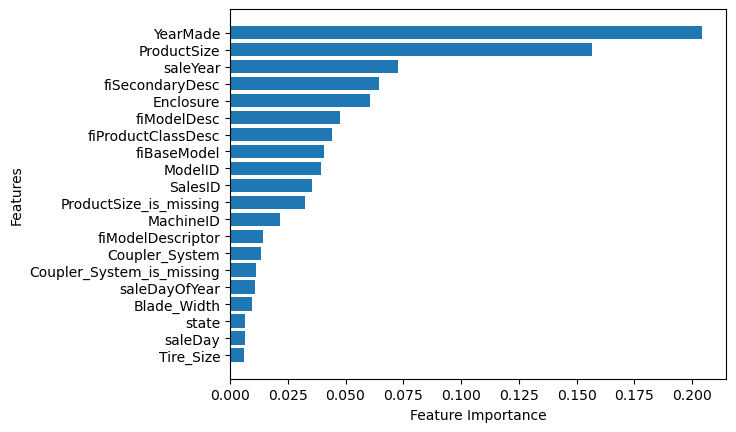

In [114]:
plot_features(x_train.columns, ideal_model.feature_importances_)

## Question to finish: Why might knowing the feature importances of a trained machine learning model be helpful?

**Final Challenge**: What other machine learning models could you try on our dataset? Hint: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

Maybe check some other regression models like `RidgeRegression` or `SGDRegressor`?  Or even look at something like `CatBoost` or `XGBoost`?
🦸🏽‍♂️